# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.10.2+cpu


# Preparing Training and Test Sets

In [2]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Prepare DataLoader

In [4]:
train_dirs = {
    'normal': 'D:\\Project\\COVID Detection form Chest X-ray Images\\DataSet\\normal',
    'viral': 'D:\\Project\\COVID Detection form Chest X-ray Images\\DataSet\\viral',
    'covid': 'D:\\Project\\COVID Detection form Chest X-ray Images\\DataSet\\covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10192 normal examples
Found 1345 viral examples
Found 3616 covid examples


In [5]:
test_dirs = {
    'normal': 'D:\\Project\\COVID Detection form Chest X-ray Images\\DataSet\\normal',
    'viral': 'D:\\Project\\COVID Detection form Chest X-ray Images\\DataSet\\viral',
    'covid': 'D:\\Project\\COVID Detection form Chest X-ray Images\\DataSet\\covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 10192 normal examples
Found 1345 viral examples
Found 3616 covid examples


In [6]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 2526
Number of test batches 2526


# Data Visualization

In [7]:
class_names = train_dataset.class_names
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

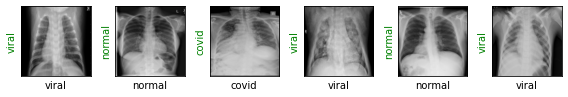

In [8]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

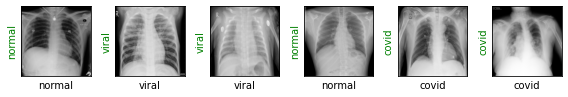

In [9]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [10]:
resnet50 = torchvision.models.resnet50(pretrained=True)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
resnet50.fc = torch.nn.Linear(in_features=2048, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=3e-5)

In [12]:
def show_preds():
    resnet50.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet50(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

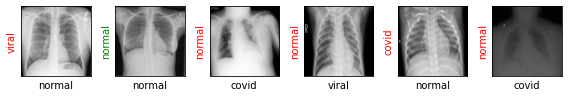

In [13]:
show_preds()

# Training the Model

In [14]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet50.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet50(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet50.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet50(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet50.train()
                
                torch.save(resnet50.state_dict(), 'resnet18-model.h5')

                if accuracy >= 0.93:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)
        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.1842, Accuracy: 0.3016


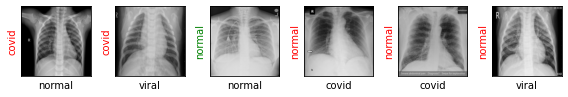

Evaluating at step 20
Validation Loss: 0.7564, Accuracy: 0.7219


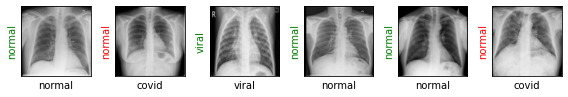

Evaluating at step 40
Validation Loss: 0.5304, Accuracy: 0.8445


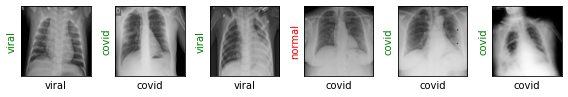

Evaluating at step 60
Validation Loss: 0.3601, Accuracy: 0.8933


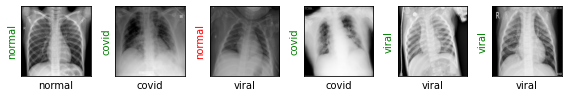

Evaluating at step 80
Validation Loss: 0.2752, Accuracy: 0.9132


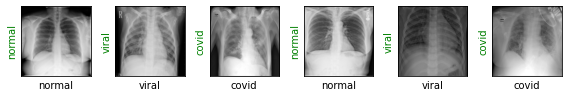

Evaluating at step 100
Validation Loss: 0.2698, Accuracy: 0.9075


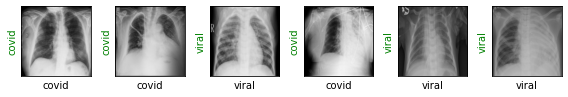

Evaluating at step 120
Validation Loss: 0.2503, Accuracy: 0.9173


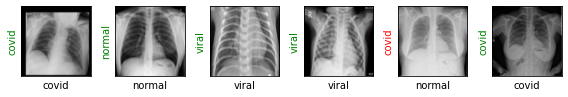

Evaluating at step 140
Validation Loss: 0.2209, Accuracy: 0.9271


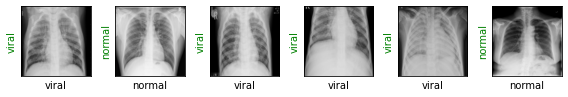

Evaluating at step 160
Validation Loss: 0.2146, Accuracy: 0.9303


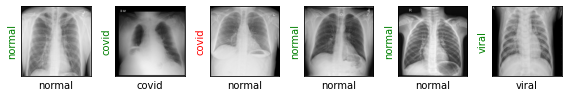

Performance condition satisfied, stopping..
Wall time: 5h 7min 38s


In [15]:
%%time
train(epochs=1)

# Final Results

In [ ]:
# show_preds()

In [17]:
from PIL import Image
from pathlib import Path
import torch
import torchvision

def model_predict(img_path):
    predict_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=(224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    model = torchvision.models.resnet50(pretrained=True)
    model.fc = torch.nn.Linear(in_features=2048, out_features=3)
    checkpoint = torch.load(Path('resnet18-model.h5'))
    model.load_state_dict(checkpoint)

    model.eval()

    image = Image.open(img_path).convert('RGB')
    image = predict_transform(image)
    print(image.shape)
    image = torch.unsqueeze(image, 0)
    print(image.shape)

    output = model(image)
    _, pred = torch.max(output, 1)
    pred=pred.item()

    label=""

    if pred==1:
        label="viral"
    elif pred==2:
        label = "covid"
    elif pred == 0:
        label = "normal"

    return label

img_path = "D:\\Project\\COVID Detection form Chest X-ray Images\\test\\COVID-5.png"
label = model_predict(img_path)
print(label)


torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
covid


In [18]:
img_path = "D:\\Project\\COVID Detection form Chest X-ray Images\\test\\Normal-1.png"
label = model_predict(img_path)
print(label)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
normal


In [19]:
img_path = "D:\\Project\\COVID Detection form Chest X-ray Images\\test\\Viral-7.png"
label = model_predict(img_path)
print(label)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
viral
